In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.quantum_info import SparsePauliOp

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="f00ee7488d13ce827aab18d868467c3a332e1620794fb5cb07c1f8e764fd37dbf2315eea0efa59c42f3c45d62f7f5b79778d752a95a2fb6363c79395484eb410",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)
 
# Load saved credentials
service = QiskitRuntimeService()

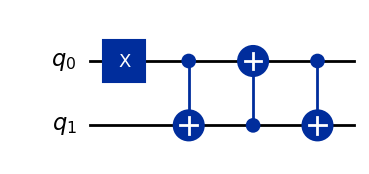

In [15]:
circ=QuantumCircuit(2)
circ.x(0)

circ.cx(0,1)
circ.cx(1,0)
circ.cx(0,1)

circ.draw("mpl")

In [21]:
pm=generate_preset_pass_manager(optimization_level=3,backend=FakeManilaV2()) 
isa_circ=pm.run(circ)

observable=SparsePauliOp("ZZ")

isa_observable=observable.apply_layout(isa_circ.layout)

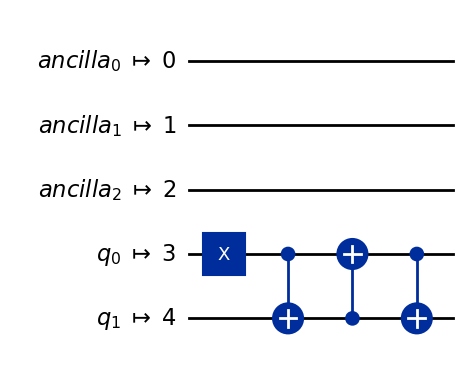

In [22]:
isa_circ.draw(output="mpl")

In [28]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
 
# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()
 
# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}
 
# Define Estimator
estimator = Estimator(mode=fake_manila, options=options)
 
# Run an expectation value calculation
job = estimator.run([(isa_circ, isa_observable)])
result = job.result()

print(f"Job Id: {job.job_id()}")
print(f"  > Expectation value: {result[0].data.evs}")
print(f"  > Metadata: {result[0].metadata}")

Job Id: 1f248fd4-782c-4473-8a11-e9158b790ac3
  > Expectation value: -0.90869140625
  > Metadata: {'target_precision': 0.015625}


In [30]:
from qiskit_ibm_runtime import QiskitRuntimeService 
service=QiskitRuntimeService()

backend_real=service.backend("ibm_brisbane")

print("Chosen Backend: ",backend_real.name)

Chosen Backend:  ibm_brisbane


In [31]:
pm=generate_preset_pass_manager(backend=backend_real,optimization_level=3)
isa_circ=pm.run(circ)

obs=SparsePauliOp("Z"*circ.num_qubits)
isa_obs=obs.apply_layout(isa_circ.layout)

print(isa_obs)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII'],
              coeffs=[1.+0.j])


In [32]:
estimator=Estimator(mode=backend_real) 

pub=estimator.run([(isa_circ,isa_obs)])
print(f"Running on: {backend_real.name}")
print(f"Job Id: {pub.job_id()}")
result=pub.result()

print(f"  > Expectation value: {result[0].data.evs}")
print(f"  > Metadata: {result[0].metadata}")

Running on: ibm_brisbane
Job Id: cvpwbt7xx5ag008h68jg
  > Expectation value: -0.9683937823834197
  > Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


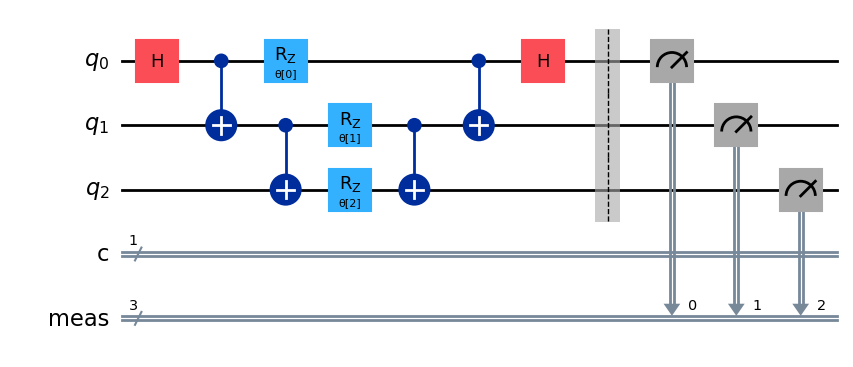

In [14]:
from qiskit.circuit import QuantumCircuit, ParameterVector
 
n = 3
thetas = ParameterVector('θ',n)
 
qc = QuantumCircuit(n, 1)
qc.h(0)
 
for i in range(n-1):
    qc.cx(i, i+1)
 
for i,t in enumerate(thetas):
    qc.rz(t, i)
 
for i in reversed(range(n-1)):
    qc.cx(i, i+1)
 
qc.h(0)
qc.measure_all()
 
qc.draw(output="mpl")

In [15]:
import numpy as np
theta_values = [np.pi/2, np.pi/2, np.pi/2]



In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [17]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

In [19]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
sampler = Sampler(backend)
job = sampler.run([(isa_circuit, theta_values)])

print(f"Job id: {job.job_id()}")
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
# Get counts from the classical register "c".
print(f" >> Counts for the all the output registers:\n{pub_result.data.meas.get_counts()}")

Job id: cvpwqme20wjg008q2e90
 >> Counts for the all the output registers:
{'000': 1809, '001': 1781, '100': 105, '010': 134, '011': 170, '101': 59, '111': 17, '110': 21}


In [20]:
circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
 
service = QiskitRuntimeService()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circuit)

In [21]:
sampler=Sampler(mode=backend)
sampler.options.execution.meas_type="avg_kerneled"

job=sampler.run([isa_circuit],shots=512)
print(f"Pub Id: {job.job_id()}")
pub_result=job.result()[0]

print(f">>> Averaged IQ data: {pub_result.data.meas}")

Pub Id: cvpwrja20wjg008q2eb0
>>> Averaged IQ data: [-5977638.5+1.5578262e+08j  2825975.5+1.7682947e+08j]
